In [9]:
# UNI BIG-DATA PROJECT / DQN IMPLEMENTIERUNG
import torch
import torch.nn as nn
import torch.optim as optim
import gym
import random
import math
import time
import numpy as np

import matplotlib.pyplot as plt

In [10]:
# if gpu is to be used
use_cuda = torch.cuda.is_available()

device = torch.device("cuda:0" if use_cuda else "cpu")
Tensor = torch.Tensor
LongTensor = torch.LongTensor

env = gym.make('MountainCar-v0')

seed_value = 23
env.seed(seed_value)
torch.manual_seed(seed_value)
random.seed(seed_value)

In [11]:
###### PARAMS ######
learning_rate = 0.01 # KLEINER MACHEN!!! beim nächsten Test, 0.01 zb
num_episodes = 1000
gamma = 1

hidden_layer = 64

replay_mem_size = 50000
batch_size = 32

egreedy = 0.9
egreedy_final = 0
egreedy_decay = 500

report_interval = 10
score_to_solve = 195

####################
goal_list = []
goal = 0
bars = []

position_list = []
velocity_list = []
color = "red"

In [12]:
number_of_inputs = env.observation_space.shape[0]
number_of_outputs = env.action_space.n

def calculate_epsilon(steps_done):
    epsilon = egreedy_final + (egreedy - egreedy_final) * \
              math.exp(-1. * steps_done / egreedy_decay )
    return epsilon

In [13]:
class ExperienceReplay(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
 
    def push(self, state, action, new_state, reward, done):
        transition = (state, action, new_state, reward, done)
        
        if self.position >= len(self.memory):
            self.memory.append(transition)
        else:
            self.memory[self.position] = transition
        
        self.position = ( self.position + 1 ) % self.capacity
        
        
    def sample(self, batch_size):
        return zip(*random.sample(self.memory, batch_size))
        
        
    def __len__(self):
        return len(self.memory)

In [14]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear1 = nn.Linear(number_of_inputs,hidden_layer)
        self.linear2 = nn.Linear(hidden_layer,number_of_outputs)

        #self.activation = nn.Tanh() # =nn.Sigmoid() AUCH TESTEN!!!!!
        #self.activation = nn.ReLU()
        self.activation = nn.Sigmoid()
        
        
    def forward(self, x):
        output1 = self.linear1(x)
        output1 = self.activation(output1)
        output2 = self.linear2(output1)

        return output2

In [15]:
class QNet_Agent(object):
    def __init__(self):
        self.nn = NeuralNetwork().to(device)

        self.loss_func = nn.MSELoss()
        #TODO: try other loss functions
        #self.loss_func = nn.SmoothL1Loss()
        
        #TODO try other optimizers
        self.optimizer = optim.Adam(params=self.nn.parameters(), lr=learning_rate)
        #self.optimizer = optim.RMSprop(params=mynn.parameters(), lr=learning_rate)
        
    def select_action(self,state,epsilon):
        
        random_for_egreedy = torch.rand(1)[0] 
        
        if random_for_egreedy > epsilon:      
            
            with torch.no_grad():
                
                state = Tensor(state).to(device)
                action_from_nn = self.nn(state)
                action = torch.max(action_from_nn,0)[1]
                action = action.item()        
        else:
            action = env.action_space.sample()
        
        return action
    
    def optimize(self):
        
        if (len(memory) < batch_size):
            return
        
        state, action, new_state, reward, done = memory.sample(batch_size)
        
        state = Tensor(state).to(device)
        new_state = Tensor(new_state).to(device)
        reward = Tensor(reward).to(device)
        action = LongTensor(action).to(device)
        done = Tensor(done).to(device)

        new_state_values = self.nn(new_state).detach()
        max_new_state_values = torch.max(new_state_values, 1)[0]
        target_value = reward + ( 1 - done ) * gamma * max_new_state_values
  
        predicted_value = self.nn(state).gather(1, action.unsqueeze(1)).squeeze(1)
        
        loss = self.loss_func(predicted_value, target_value)
    
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        
        #Q[state, action] = reward + gamma * torch.max(Q[new_state])

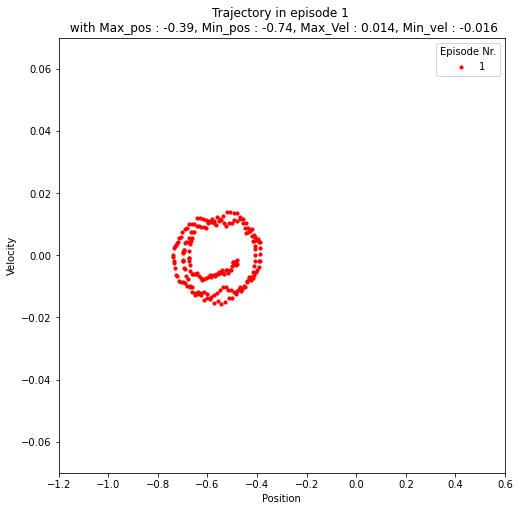

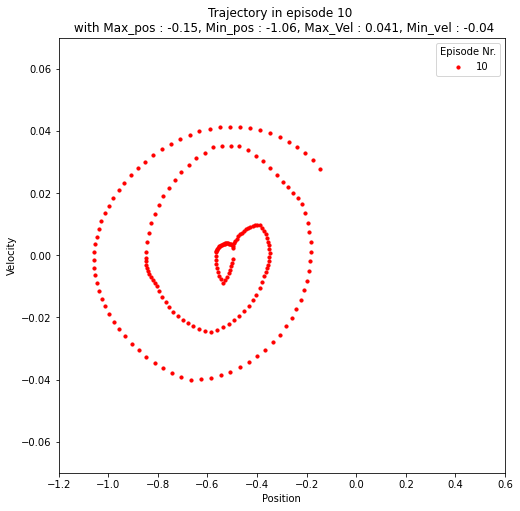

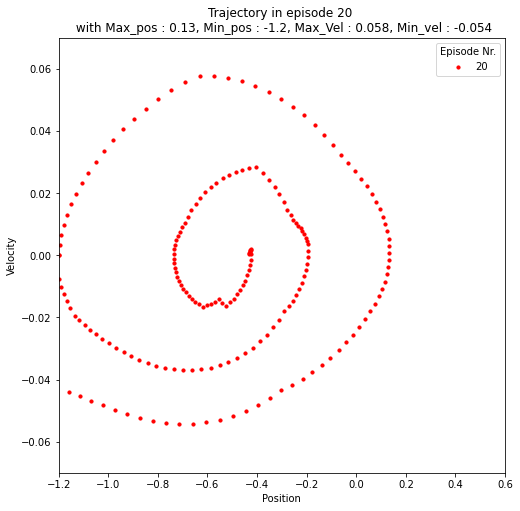

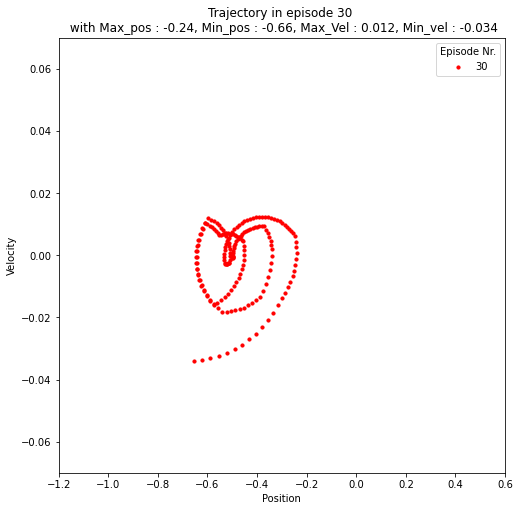

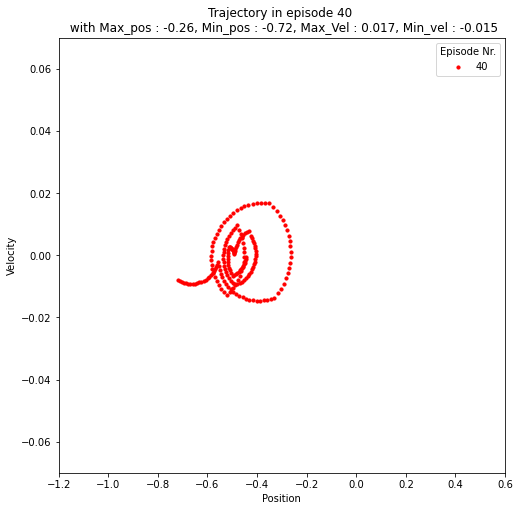

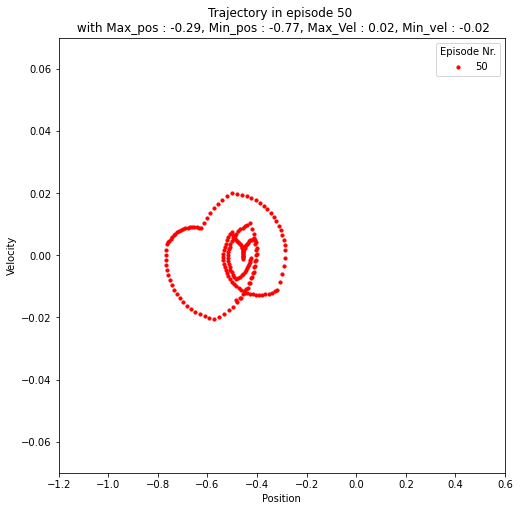

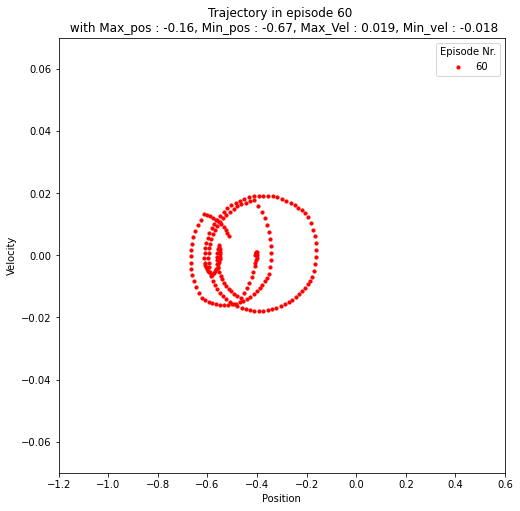

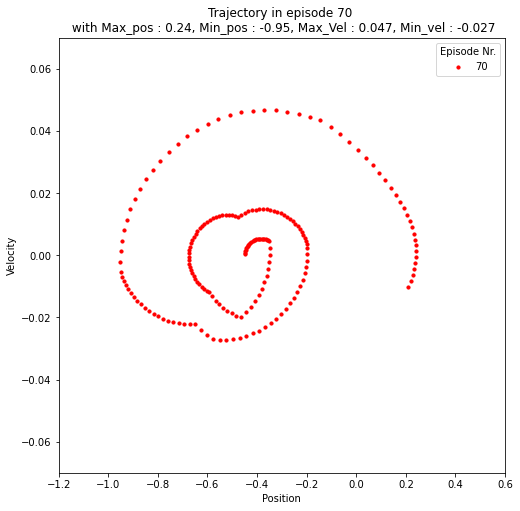

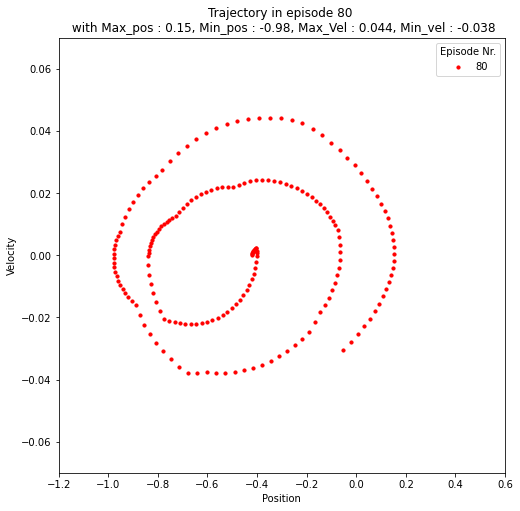

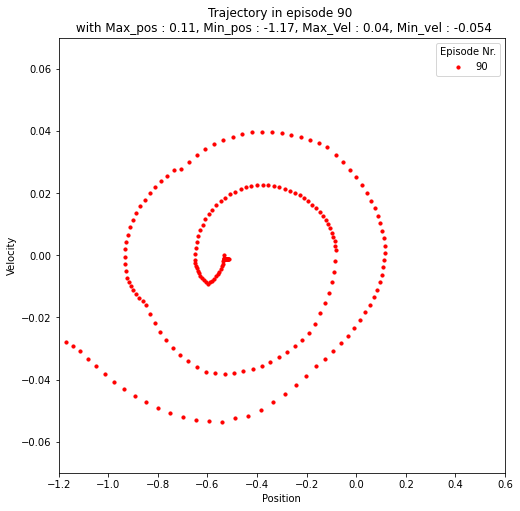

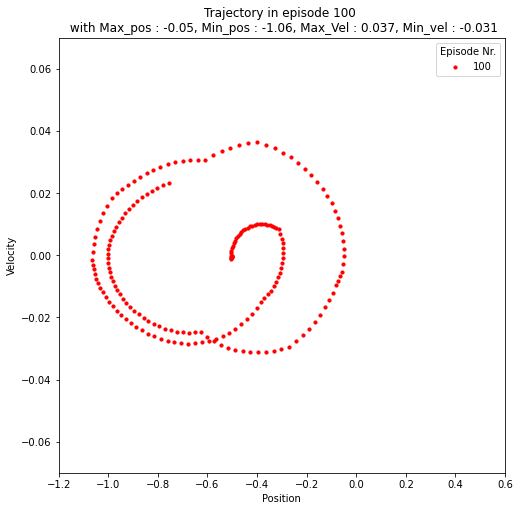

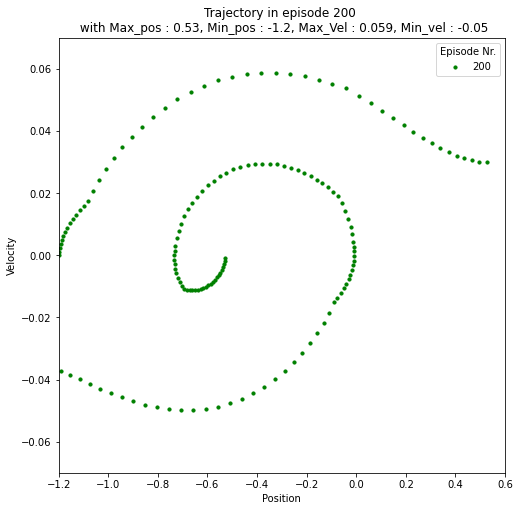

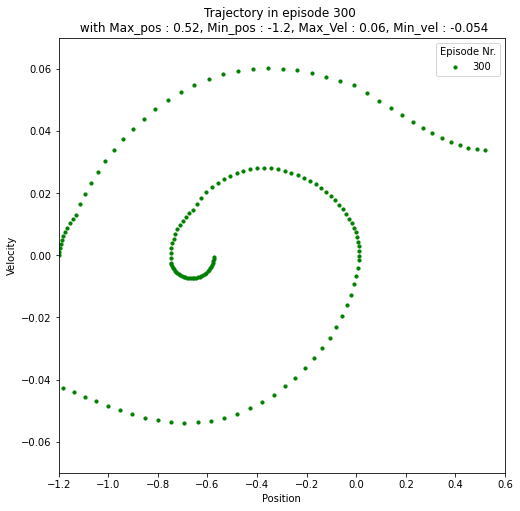

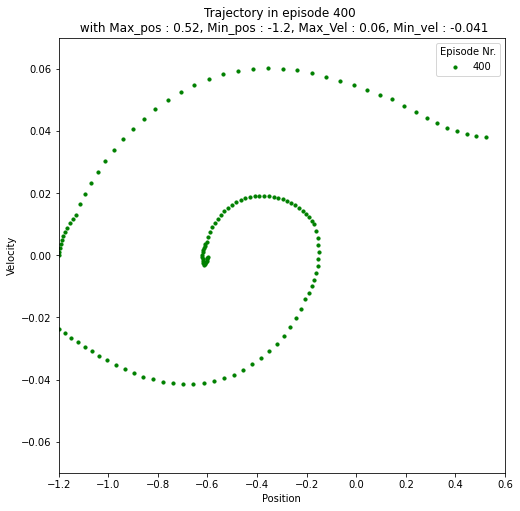

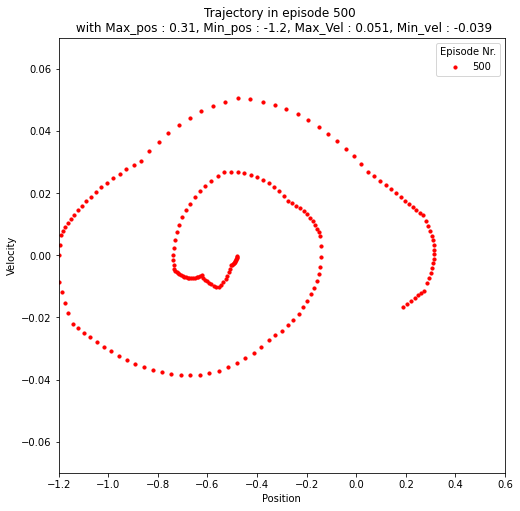

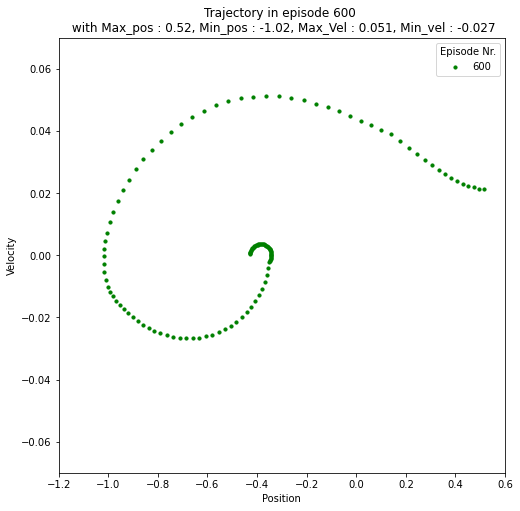

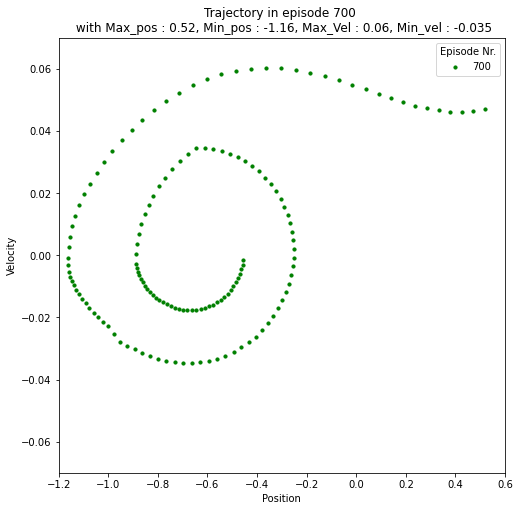

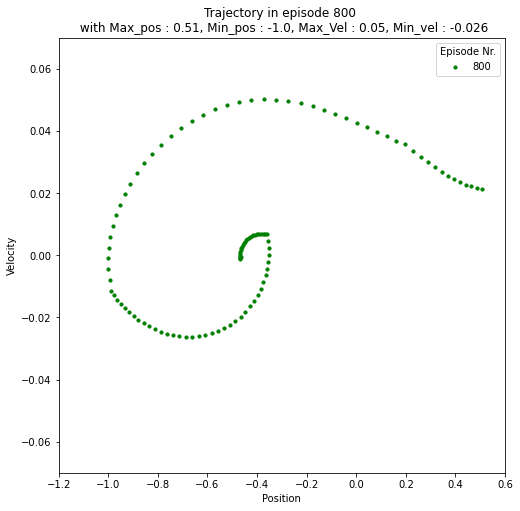

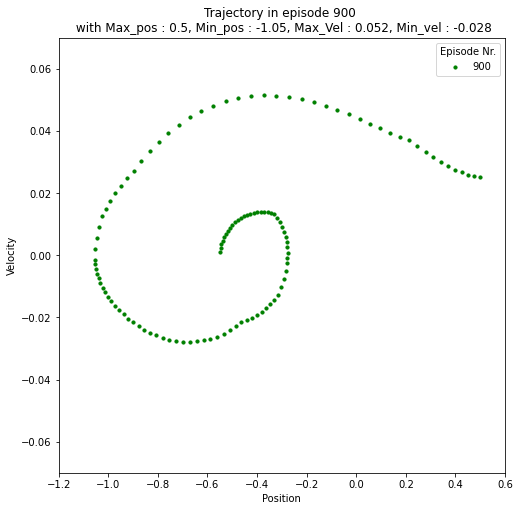

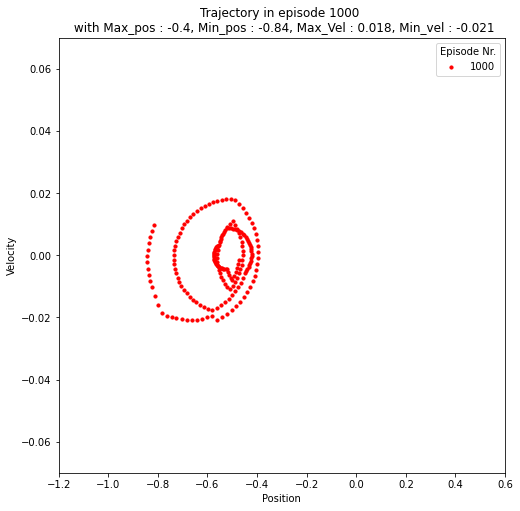

In [16]:
memory = ExperienceReplay(replay_mem_size)
qnet_agent = QNet_Agent()

steps_total = []
reward_list = []
ave_reward_list = []

frames_total = 0 
solved_after = 0
solved = False

start_time = time.time()

goal = 0

for i_episode in range(num_episodes):
    
    state = env.reset()
    tot_reward = 0
    reward_list = []
    
  
    #Visualisierungslisten reinigen:
    position_list.clear()
    velocity_list.clear()
    
    step = 0
    #for step in range(100):
    while True:
        
        step += 1
        frames_total += 1
        
        epsilon = calculate_epsilon(frames_total)
        
        #action = env.action_space.sample()
        action = qnet_agent.select_action(state, epsilon)
        
        new_state, reward, done, info = env.step(action)

        memory.push(state, action, new_state, reward, done)
        qnet_agent.optimize()
        
        state = new_state
        tot_reward += reward
        reward_list.append(tot_reward)
        #env.render()
        
        #Visualisierungslisten füllen
        position_list.append(new_state[0])
        velocity_list.append(new_state[1])
        
        if done:
            steps_total.append(step)
            ave_reward = np.mean(reward_list)
            ave_reward_list.append(ave_reward)
            
            if new_state[0] < env.goal_position:
                color = "red"
                
                if (i_episode+1) == 1:
                    ma_p = float("{0:.2f}".format(max(position_list)))
                    mi_p = float("{0:.2f}".format(min(position_list)))
                    ma_v = float("{0:.3f}".format(max(velocity_list)))
                    mi_v = float("{0:.3f}".format(min(velocity_list)))
                    fig = plt.figure(figsize=(8,8))
                    plt.scatter(position_list, velocity_list, s=10, c=color, label= i_episode+1)
                    plt.xlabel("Position")
                    plt.ylabel("Velocity")
                    plt.title("Trajectory in episode {} \n with Max_pos : {}, Min_pos : {}, Max_Vel : {}, Min_vel : {}".format(i_episode+1, ma_p, mi_p, ma_v, mi_v))
                    l1 = plt.legend(loc="upper right", title="Episode Nr.")
                    plt.xlim(-1.2, 0.6)
                    plt.ylim(-0.07, 0.07)
                    e = i_episode+1
                    plt.savefig(f"spiralen_dqn_sig_lr01/000{e}_nogoel_spirale_DQN_Sig_lr01.png", facecolor='w', edgecolor='w')
                    #plt.show
                
                if (i_episode+1) % 10 == 0 and (i_episode+1) < 100:
                    ma_p = float("{0:.2f}".format(max(position_list)))
                    mi_p = float("{0:.2f}".format(min(position_list)))
                    ma_v = float("{0:.3f}".format(max(velocity_list)))
                    mi_v = float("{0:.3f}".format(min(velocity_list)))
                    fig = plt.figure(figsize=(8,8))
                    plt.scatter(position_list, velocity_list, s=10, c=color, label= i_episode+1)
                    plt.xlabel("Position")
                    plt.ylabel("Velocity")
                    plt.title("Trajectory in episode {} \n with Max_pos : {}, Min_pos : {}, Max_Vel : {}, Min_vel : {}".format(i_episode+1, ma_p, mi_p, ma_v, mi_v))
                    l1 = plt.legend(loc="upper right", title="Episode Nr.")
                    plt.xlim(-1.2, 0.6)
                    plt.ylim(-0.07, 0.07)
                    e = i_episode+1
                    plt.savefig(f"spiralen_dqn_sig_lr01/000{e}_nogoel_spirale_DQN_Sig_lr01.png", facecolor='w', edgecolor='w')
                    #plt.show
                
                if (i_episode+1) % 100 == 0:
                    ma_p = float("{0:.2f}".format(max(position_list)))
                    mi_p = float("{0:.2f}".format(min(position_list)))
                    ma_v = float("{0:.3f}".format(max(velocity_list)))
                    mi_v = float("{0:.3f}".format(min(velocity_list)))
                    fig = plt.figure(figsize=(8,8))
                    plt.scatter(position_list, velocity_list, s=10, c=color, label= i_episode+1)
                    plt.xlabel("Position")
                    plt.ylabel("Velocity")
                    plt.title("Trajectory in episode {} \n with Max_pos : {}, Min_pos : {}, Max_Vel : {}, Min_vel : {}".format(i_episode+1, ma_p, mi_p, ma_v, mi_v))
                    l1 = plt.legend(loc="upper right", title="Episode Nr.")
                    plt.xlim(-1.2, 0.6)
                    plt.ylim(-0.07, 0.07)
                    e = i_episode+1
                    plt.savefig(f"spiralen_dqn_sig_lr01/000{e}_nogoel_spirale_DQN_Sig_lr01.png", facecolor='w', edgecolor='w')
                    #plt.show 
            
            if new_state[0] >= env.goal_position:
                goal +=1
                
                color = "green"
                if (i_episode+1) % 100 == 0:
                    ma_p = float("{0:.2f}".format(max(position_list)))
                    mi_p = float("{0:.2f}".format(min(position_list)))
                    ma_v = float("{0:.3f}".format(max(velocity_list)))
                    mi_v = float("{0:.3f}".format(min(velocity_list)))
                    fig = plt.figure(figsize=(8,8))
                    plt.scatter(position_list, velocity_list, s=10, c=color, label= i_episode+1)
                    plt.xlabel("Position")
                    plt.ylabel("Velocity")
                    plt.title("Trajectory in episode {} \n with Max_pos : {}, Min_pos : {}, Max_Vel : {}, Min_vel : {}".format(i_episode+1, ma_p, mi_p, ma_v, mi_v))
                    l1 = plt.legend(loc="upper right", title="Episode Nr.")
                    plt.xlim(-1.2, 0.6)
                    plt.ylim(-0.07, 0.07)
                    e = i_episode+1
                    plt.savefig(f"spiralen_dqn_sig_lr01/000{e}_goel_spirale_DQN_Sig_lr01.png", facecolor='w', edgecolor='w')
                    #plt.show

            if (i_episode+1) % 100 == 0:
                #ave_reward = np.mean(reward_list)
                #ave_reward_list.append(ave_reward)
                reward_list = []
                goal_list.append(goal)
                goal=0
                bars.append(str(i_episode+1))
            
            break

            env.close()
env.env.close()


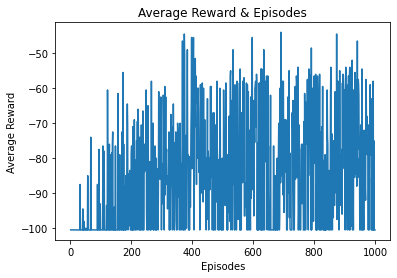

In [17]:
plt.plot((np.arange(len(ave_reward_list)) + 1), ave_reward_list)
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.title('Average Reward & Episodes')
plt.savefig(f"spiralen_dqn_sig_lr01/ave_reward_DQN_Sig_lr01.png", facecolor='w', edgecolor='w')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

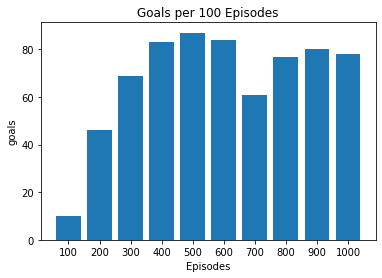

In [18]:
plt.bar(bars,goal_list, width = 0.8)
plt.xlabel("Episodes")
plt.ylabel("goals")
plt.title("Goals per 100 Episodes")
plt.savefig(f"spiralen_dqn_sig_lr01/goals_per_100_ep_DQN_Sig_lr01.png", facecolor='w', edgecolor='w')
plt.show

In [ ]:
goal

In [19]:
goal_list


[10, 46, 69, 83, 87, 84, 61, 77, 80, 78]

In [ ]:
len(bars)